## Calculation Testing Examples

In [10]:
# imports
import MDAnalysis as mda
from transport_analysis.velocityautocorr import VelocityAutocorr as VACF

# needed for the test examples in this notebook
import numpy as np

# test data for this example
from MDAnalysis.tests.datafiles import PRM_NCBOX, TRJ_NCBOX

In [11]:
# test data with velocities
u = mda.Universe(PRM_NCBOX, TRJ_NCBOX)
ag_vels = u.select_atoms("name O and resname WAT and resid 1-10")

In [12]:
# confirm that analysis runs for test data with velocities (PRM_NCBOX, TRJ_NCBOX)
v = VACF(ag_vels, fft=True)
v.run()

print("v:")
print(v.results.timeseries)

# confirm analysis uses float64
print(v.results.timeseries.dtype)

v:
[ 4.22902895e+01 -2.69143315e+00  6.98534787e-01  2.97003597e+00
  6.34654795e-01  1.23400236e+00 -2.78565552e+00  7.25828978e-01
 -1.14432591e-02 -6.46827198e+00]
float64


### Unit Velocity Trajectory Tests

In [14]:
# set unit velocity trajectory to have 10 frames
NSTEP = 10

# Step trajectory of unit velocities for a single particle i.e. v = 0 at t = 0,
# v = 1 at t = 1, v = 2 at t = 2, etc. for all components x, y, z
v_test = np.arange(NSTEP)
velocities = np.vstack([v_test, v_test, v_test]).T
# NSTEP frames x 1 atom x 3 dimensions, where NSTEP = 10
velocities_reshape = velocities.reshape([NSTEP, 1, 3])
step_vtraj = mda.Universe.empty(1, n_frames=NSTEP, velocities=True)
for i, ts in enumerate(step_vtraj.trajectory):
    step_vtraj.atoms.velocities = velocities_reshape[i]

# Expected VACF results for unit velocity trajectory
# At time t, VACF is:
# sum_{x=0}^{N - 1 - t} x*(x + t) * n_dim / n_frames
# n_dim = 3 (typically) and n_frames = total_frames - t
def characteristic_poly(last, n_dim, first=0, step=1):
    diff = last - first
    frames_used = diff // step + 1 if diff % step != 0 else diff / step
    frames_used = int(frames_used)
    result = np.zeros(frames_used)
    for t in range(first, last, step):
        sum = 0
        sum = np.dtype("float64").type(sum)
        lagtime = t - first
        for x in range(first, (last - lagtime), step):
            sum += x * (x + lagtime)
        current_index = int(lagtime / step)
        vacf = sum * n_dim / (frames_used - current_index)
        result[current_index] = vacf
    return result

# the following test examples set n_dim to 3
# all of the following calculations should give the same result
# and use float64

poly = characteristic_poly(NSTEP, 3)

# result for analysis run on unit velocity trajectory WITH FFT
v_simple = VACF(step_vtraj.atoms, fft=True)
v_simple.run()
print("v_simple:")
print(v_simple.results.timeseries)
print(v_simple.results.timeseries.dtype)

# result from characteristic_poly (expected VACF results)
print("poly:")
print(poly)
print(poly.dtype)

# result for analysis run on unit velocity trajectory WITHOUT FFT
v_window = VACF(step_vtraj.atoms, fft=False)
v_window.run()
print("v_window:")
print(v_window.results.timeseries)
print(v_window.results.timeseries.dtype)

v_simple:
[ 8.5500000e+01  8.0000000e+01  7.3500000e+01  6.6000000e+01
  5.7500000e+01  4.8000000e+01  3.7500000e+01  2.6000000e+01
  1.3500000e+01 -1.0658141e-14]
float64
poly:
[85.5 80.  73.5 66.  57.5 48.  37.5 26.  13.5  0. ]
float64
v_window:
[85.5 80.  73.5 66.  57.5 48.  37.5 26.  13.5  0. ]
float64


## Plotting Examples

In [ ]:
# if using only the terminal, the plots may not appear automatically like they do here
# you will then need the following:
# import matplotlib.pyplot as plt

# then after running the desired plotting function, run:
# plt.show()

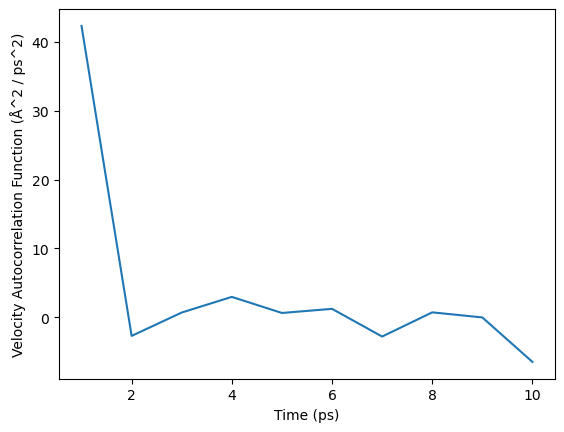

In [16]:
# plot vacf for test data with velocities (PRM_NCBOX, TRJ_NCBOX)
v_vacf_plot = v.plot_vacf()

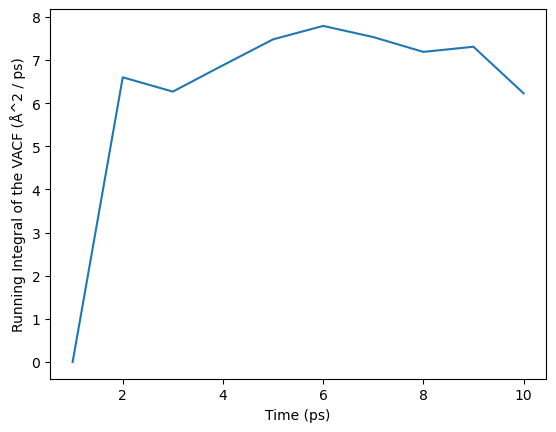

In [17]:
# plot running integral for test data with velocities (PRM_NCBOX, TRJ_NCBOX)
v_running_integral_plot = v.plot_running_integral()

## Exceptions

In [18]:
# Running without velocities raises NoDataError
u_no_vels = mda.Universe.empty(10, n_frames=5, velocities=False)
v = VACF(u_no_vels.atoms).run()

NoDataError: VACF computation requires velocities in the trajectory